In [214]:
import pandas as pd

# Load the dataset
df = pd.read_csv('ecommerce_customer_data_large.csv')
df.head()  # Display the first few rows


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [216]:
# Check data types and missing values
df.info()

# Summary statistics
df.describe()

# Check for null values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64

In [218]:
# Fill missing Returns with 0 (indicating no returns)
df.fillna({'Returns':0}, inplace=True)

# Verify the changes
print("Missing values in Returns after handling:", df['Returns'].isnull().sum())


Missing values in Returns after handling: 0


In [220]:
# Convert 'Purchase Date' to datetime
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

# Handle missing values (example: filling missing ages with the median)
df.fillna({'Customer Age': df['Customer Age'].median()}, inplace=True)


df.head()
df.to_csv('cleaned_cs_dataset.csv',index= False)
print("cleaned dataset have been saved successfully")

cleaned dataset have been saved successfully


In [222]:
import datetime

# Define a reference date (e.g., the most recent purchase)
today_date = datetime.datetime.now()

# Calculate Recency (difference in days from the last purchase)
df['Recency'] = (today_date - df['Purchase Date']).dt.days


In [224]:
# Calculate the frequency of purchases for each customer
frequency = df.groupby('Customer ID')['Purchase Date'].count().reset_index()
frequency.columns = ['Customer ID', 'Frequency']

# Merge this frequency data with your main dataframe
df = pd.merge(df, frequency, on='Customer ID', how='left')


In [226]:
# If 'Monetary' already exists, drop it
if 'Monetary' in df.columns:
    df.drop(columns=['Monetary'], inplace=True)

# Calculate the monetary value (total amount spent) by each customer
monetary = df.groupby('Customer ID')['Total Purchase Amount'].sum().reset_index()
monetary.columns = ['Customer ID', 'Monetary']

# Now, merge this monetary data with your main dataframe
df = pd.merge(df, monetary, on='Customer ID', how='left')


In [228]:
from sklearn.preprocessing import StandardScaler

# Select RFM columns
rfm = df[['Recency', 'Frequency', 'Monetary']]

# Scale the values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
print(rfm)
print(rfm_scaled)

        Recency  Frequency  Monetary
0           708          5     10755
1          1425          5     10755
2          1732          5     10755
3           814          5     10755
4          1440          5     10755
...         ...        ...       ...
249995      807          1      3664
249996     1406          1      4374
249997      882          1      5296
249998     1383          1      2517
249999     1676          1      3634

[250000 rows x 3 columns]
[[-1.39111226 -0.44499648 -0.79108145]
 [ 0.44665194 -0.44499648 -0.79108145]
 [ 1.23353285 -0.44499648 -0.79108145]
 ...
 [-0.94512764 -2.23388392 -1.56543481]
 [ 0.33900048 -2.23388392 -1.95963301]
 [ 1.08999757 -2.23388392 -1.80118774]]


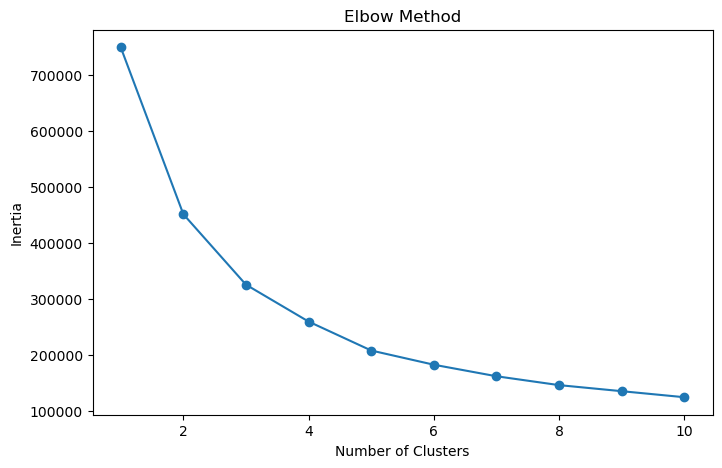

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Use the Elbow Method to find the optimal number of clusters
inertia = []
for k in range(1, 11):  # Try 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [24]:
# Fit K-Means with the chosen number of clusters (here 5)
optimal_k = 5  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(rfm_scaled)

# Add the cluster labels to the dataframe
df['Cluster'] = kmeans.labels_


In [25]:
# Group by clusters and calculate the mean values for RFM metrics
cluster_summary = df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_summary)


             Recency  Frequency      Monetary
Cluster                                      
0         892.918048   6.993348  19358.595476
1        1595.243590   6.749859  18645.278345
2         914.635506   4.169098  10599.493162
3        1284.618249   9.921606  28926.617395
4        1586.988708   3.982668  10045.814404


C:\Users\HARATHI\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


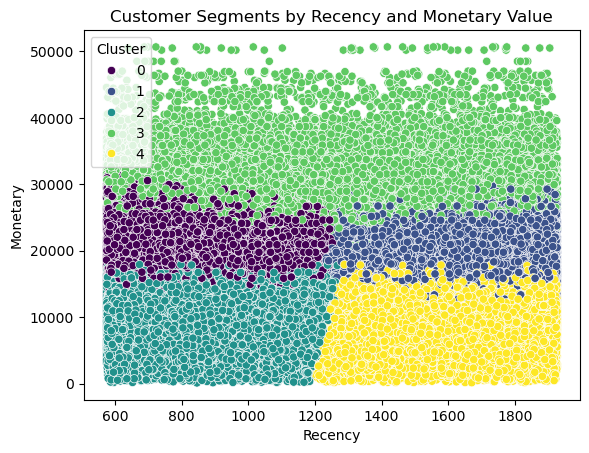

In [26]:
import seaborn as sns

# Visualize clusters with a scatter plot
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=df, palette='viridis')
plt.title('Customer Segments by Recency and Monetary Value')
plt.show()


In [31]:
# View the cluster profiles with additional columns
cluster_profiles = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer Age': 'mean',
    'Gender': lambda x: x.value_counts().index[0]  # Most common gender
})
# Round the 'Customer Age' column to whole numbers for better readability
cluster_profiles['Customer Age'] = cluster_profiles['Customer Age'].round(0)
print(cluster_profiles)


             Recency  Frequency      Monetary  Customer Age  Gender
Cluster                                                            
0         892.918048   6.993348  19358.595476          44.0    Male
1        1595.243590   6.749859  18645.278345          44.0    Male
2         914.635506   4.169098  10599.493162          43.0  Female
3        1284.618249   9.921606  28926.617395          45.0    Male
4        1586.988708   3.982668  10045.814404          43.0    Male


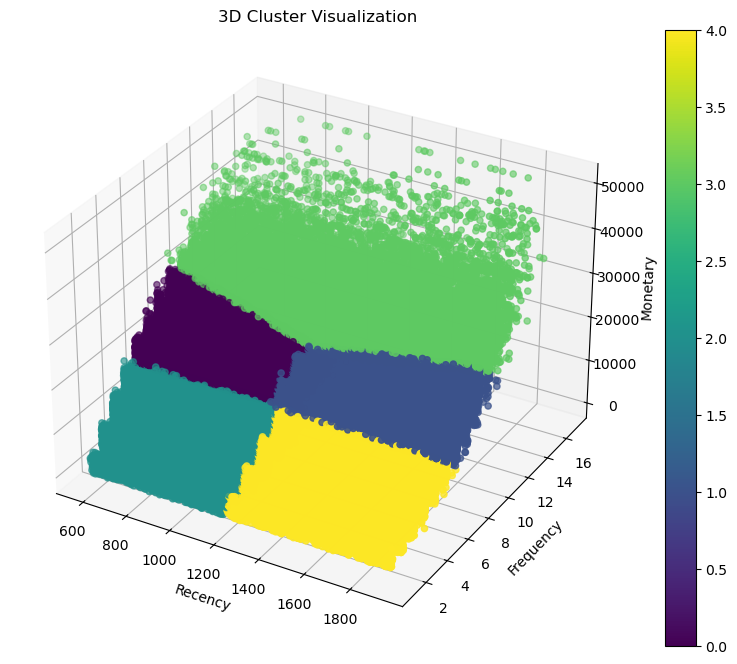

In [33]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df['Recency'], df['Frequency'], df['Monetary'], c=df['Cluster'], cmap='viridis')
plt.colorbar(sc)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Cluster Visualization')
plt.show()


In [35]:
from sklearn.metrics import silhouette_score

score = silhouette_score(rfm_scaled, df['Cluster'])
print(f'Silhouette Score: {score}')


Silhouette Score: 0.31293870003888496


In [37]:
# Set optimal_k based on your analysis
#optimal_k = 5  # Example value
#from sklearn.cluster import KMeans

# Define and fit the model
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42)
kmeans.fit(rfm_scaled)


KMeans(n_clusters=5, n_init=10, random_state=42)

In [39]:
import joblib

# Save the model
joblib.dump(kmeans, 'kmeans_model.pkl')

# To load the model later
kmeans_loaded = joblib.load('kmeans_model.pkl')


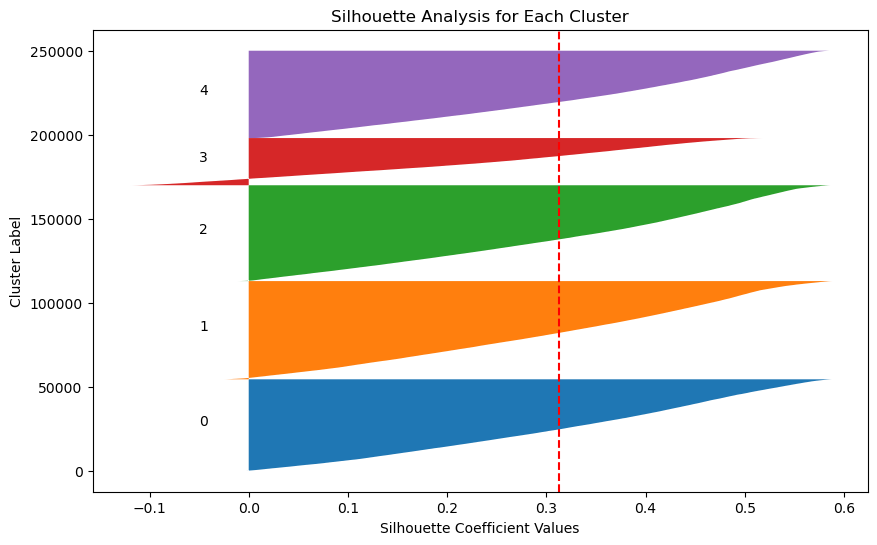

In [41]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# Calculate silhouette scores for each data point
sample_silhouette_values = silhouette_samples(rfm_scaled, df['Cluster'])

# Plot silhouette scores
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(optimal_k):
    # Aggregate silhouette scores for the cluster and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[df['Cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for spacing between plots

plt.title('Silhouette Analysis for Each Cluster')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Label')
plt.axvline(x=score, color='red', linestyle='--')
plt.show()


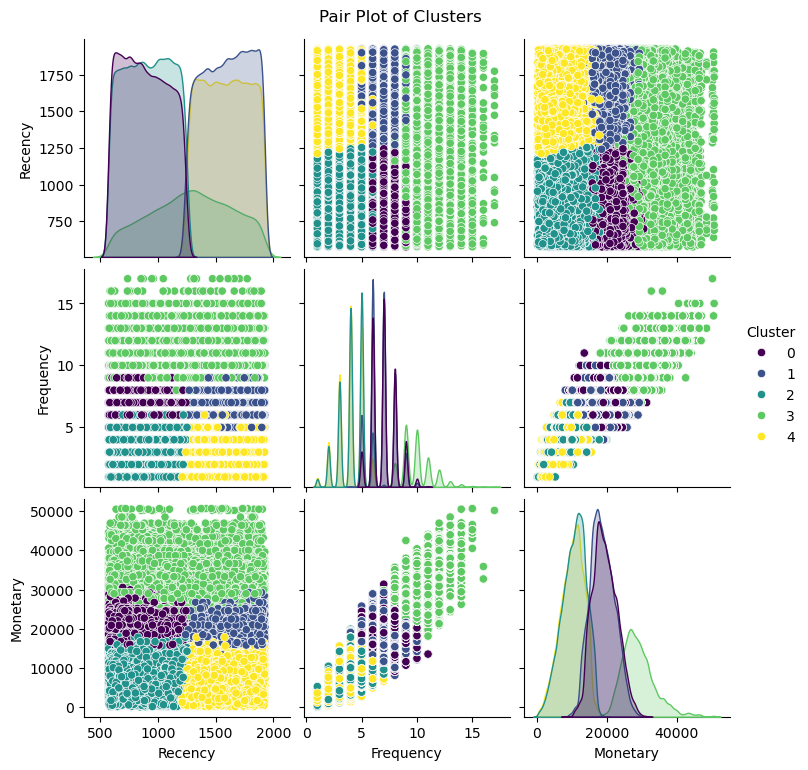

In [43]:
sns.pairplot(df, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'], palette='viridis')
plt.suptitle('Pair Plot of Clusters', y=1.02)
plt.show()

In [44]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Scale the RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

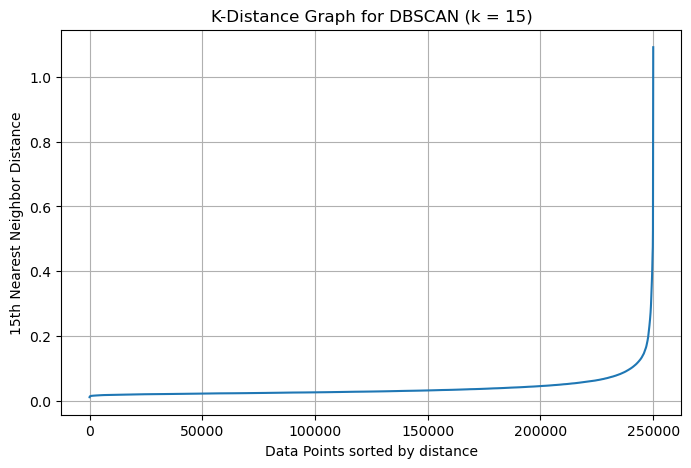

In [82]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

min_samples = 15  # should match your DBSCAN's min_samples

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)

# Take the distance to the 15th nearest neighbor
distances = np.sort(distances[:, min_samples - 1])  # zero-indexed, so 14
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title("K-Distance Graph for DBSCAN (k = 15)")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("15th Nearest Neighbor Distance")
plt.grid(True)
plt.show()


DBSCAN_Cluster
 0     44482
 5     43700
 1     36775
 3     35182
 10    25358
 6     21099
 4     16132
 7      9103
 8      8322
 9      4020
 12     2224
 11     1653
-1      1347
 2       447
 19       23
 14       22
 20       21
 21       20
 17       15
 13       15
 15       15
 16       14
 18       11
Name: count, dtype: int64


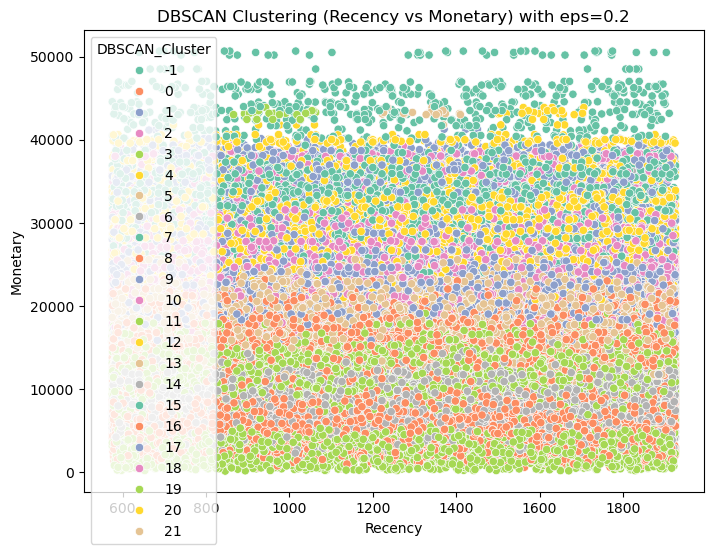

In [67]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
# Try with new eps
dbscan = DBSCAN(eps=0.2, min_samples=15)
dbscan_labels = dbscan.fit_predict(rfm_scaled)

# Assign the new labels
rfm = rfm.copy()  # Prevent SettingWithCopyWarning
rfm['DBSCAN_Cluster'] = dbscan_labels

# Cluster distribution
print(rfm['DBSCAN_Cluster'].value_counts())

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='DBSCAN_Cluster', palette='Set2')
plt.title('DBSCAN Clustering (Recency vs Monetary) with eps=0.2')
plt.show()



In [73]:
cluster_summary = rfm.groupby('DBSCAN_Cluster').agg({
    'Recency': ['mean', 'count'],
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

# Optional: flatten MultiIndex columns
cluster_summary.columns = ['Recency_Mean', 'Count', 'Frequency_Mean', 'Monetary_Mean']
cluster_summary = cluster_summary.sort_values('Count', ascending=False)

print(cluster_summary)



                Recency_Mean  Count  Frequency_Mean  Monetary_Mean
DBSCAN_Cluster                                                    
 0                   1252.11  44482            5.00       13637.26
 5                   1247.94  43700            6.00       16358.63
 1                   1248.27  36775            7.00       19073.48
 3                   1251.80  35182            4.00       10941.72
 10                  1253.36  25358            8.00       21735.57
 6                   1250.71  21099            3.00        8151.13
 4                   1248.77  16132            9.00       24368.17
 7                   1255.31   9103           10.00       27072.35
 8                   1249.72   8322            2.00        5475.41
 9                   1244.88   4020           11.00       30411.68
 12                  1247.24   2224           12.00       32328.90
 11                  1251.04   1653            1.00        2745.05
-1                   1245.23   1347           12.35       3433

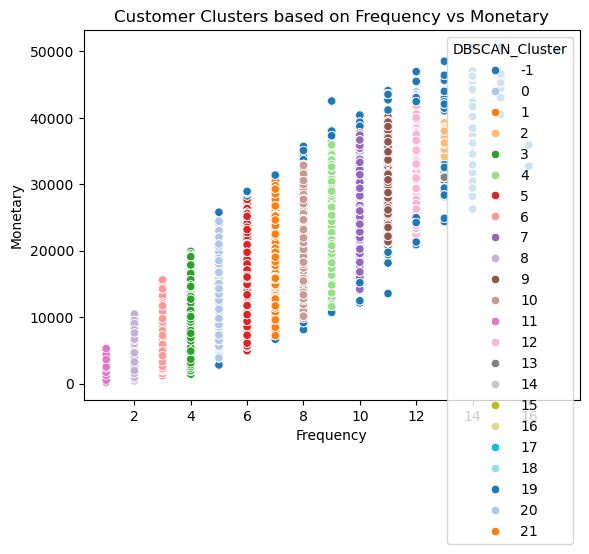

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='DBSCAN_Cluster', palette='tab20')
plt.title("Customer Clusters based on Frequency vs Monetary")
plt.show()


In [77]:
cluster_labels = {
    2: 'Champions',
    9: 'Loyal Customers',
    8: 'Occasional Spenders',
    11: 'One-time Buyers',
    -1: 'Outliers',
    19: 'Big Spenders',
    # add more based on your judgment
}


In [79]:
rfm['Cluster_Label'] = rfm['DBSCAN_Cluster'].map(cluster_labels)


In [86]:
outliers = rfm[rfm['DBSCAN_Cluster'] == -1]
print(f"Outliers detected: {len(outliers)}")


Outliers detected: 1347


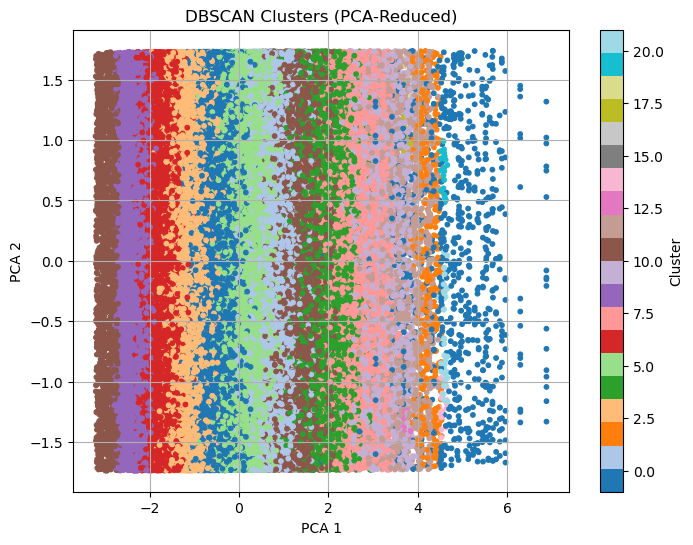

In [88]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=rfm['DBSCAN_Cluster'], cmap='tab20', s=10)
plt.title('DBSCAN Clusters (PCA-Reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


In [96]:
rfm_no_outliers = rfm[rfm['DBSCAN_Cluster'] != -1]

summary = rfm_no_outliers.groupby('DBSCAN_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).round(2)

summary['Count'] = rfm_no_outliers.groupby('DBSCAN_Cluster').size()

print(summary)



                Recency  Frequency  Monetary  Count
DBSCAN_Cluster                                     
0               1252.11        5.0  13637.26  44482
1               1248.27        7.0  19073.48  36775
2               1247.91       13.0  36539.06    447
3               1251.80        4.0  10941.72  35182
4               1248.77        9.0  24368.17  16132
5               1247.94        6.0  16358.63  43700
6               1250.71        3.0   8151.13  21099
7               1255.31       10.0  27072.35   9103
8               1249.72        2.0   5475.41   8322
9               1244.88       11.0  30411.68   4020
10              1253.36        8.0  21735.57  25358
11              1251.04        1.0   2745.05   1653
12              1247.24       12.0  32328.90   2224
13              1781.80       13.0  31306.20     15
14              1718.95       14.0  36472.45     22
15              1569.47       13.0  30375.73     15
16              1517.00       11.0  19095.00     14
17          

C:\Users\HARATHI\AppData\Local\Temp\ipykernel_9620\3397639474.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_no_outliers['PCA1'] = pca_components[:, 0]
C:\Users\HARATHI\AppData\Local\Temp\ipykernel_9620\3397639474.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_no_outliers['PCA2'] = pca_components[:, 1]


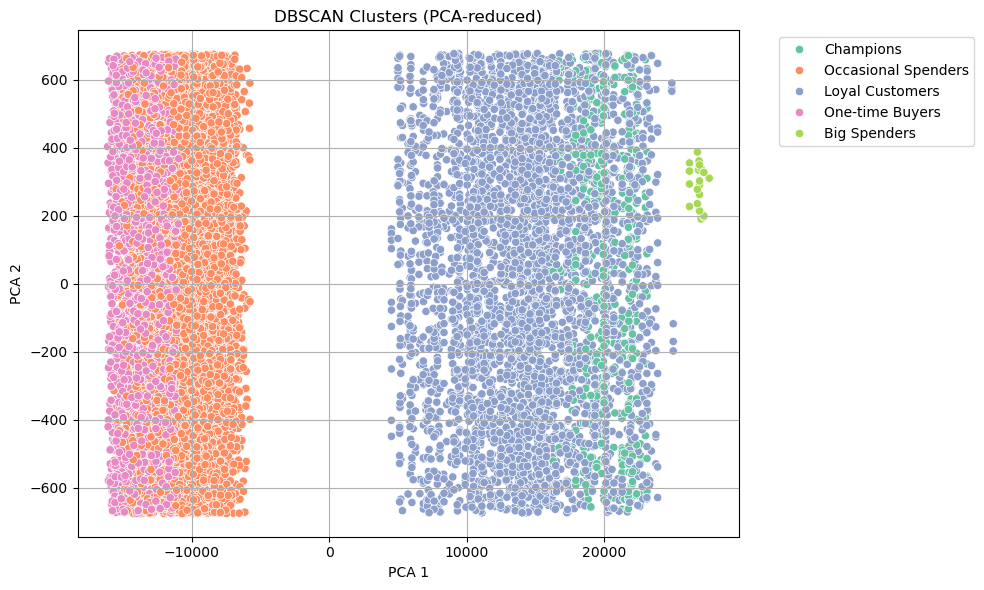

In [98]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_no_outliers[['Recency', 'Frequency', 'Monetary']])

rfm_no_outliers['PCA1'] = pca_components[:, 0]
rfm_no_outliers['PCA2'] = pca_components[:, 1]

# Plotting the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm_no_outliers, x='PCA1', y='PCA2', hue='Cluster_Label', palette='Set2')
plt.title('DBSCAN Clusters (PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


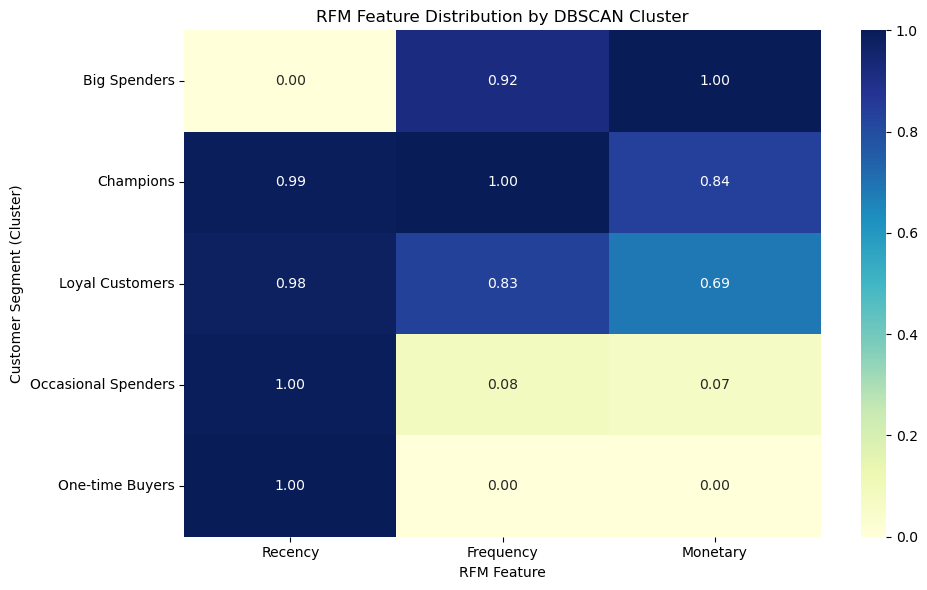

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Group by cluster and calculate the mean of RFM values
cluster_rfm = rfm_no_outliers.groupby('Cluster_Label')[['Recency', 'Frequency', 'Monetary']].mean()

# Step 2: Normalize the data for better visualization
cluster_rfm_normalized = cluster_rfm.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Step 3: Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_rfm_normalized, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('RFM Feature Distribution by DBSCAN Cluster')
plt.ylabel('Customer Segment (Cluster)')
plt.xlabel('RFM Feature')
plt.tight_layout()
plt.show()


In [186]:
print(df.columns)


Index(['Customer ID', 'Purchase Date', 'Product Price', 'Quantity',
       'Total Purchase Amount', 'Payment Method', 'Customer Age', 'Returns',
       'Customer Name', 'Age', 'Churn', 'Recency', 'Frequency', 'Monetary',
       'Cluster', 'Gender_Male', 'Product Category_Clothing',
       'Product Category_Electronics', 'Product Category_Home',
       'Avg_Spend_Per_Purchase', 'Return_Rate', 'Monetary_Per_Unit',
       'Recency_Rank', 'Frequency_Rank', 'High_Value_Customer', 'Return_Ratio',
       'Avg_Purchase_Interval', 'Spend_Per_Visit', 'Total_Units_Bought',
       'Total_Return_Amount', 'Spend_Return_Ratio', 'Recency_norm',
       'Frequency_norm', 'Monetary_norm', 'Customer_Loyalty_Score'],
      dtype='object')


In [192]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Feature selection
features = ['Customer Age', 'Gender', 'Product Category', 'Product Price', 'Quantity', 'Total Purchase Amount']
X = df[features]

[[32827 11740]
 [22448  7985]]
              precision    recall  f1-score   support

         0.0       0.59      0.74      0.66     44567
         1.0       0.40      0.26      0.32     30433

    accuracy                           0.54     75000
   macro avg       0.50      0.50      0.49     75000
weighted avg       0.52      0.54      0.52     75000



<Axes: title={'center': 'Feature Importance'}>

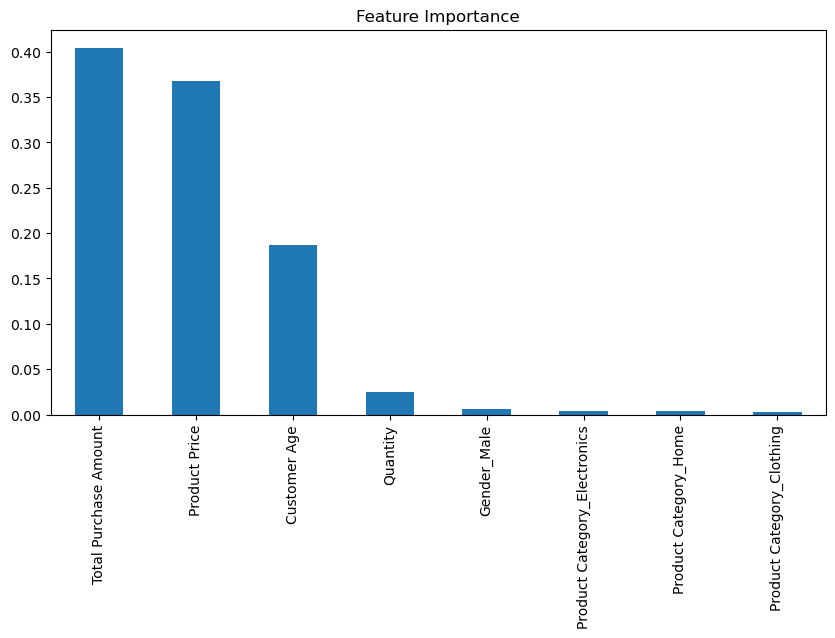

In [194]:


# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Target: Returns (0 or 1)
y = df['Returns']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title="Feature Importance")


In [196]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)


In [198]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rfc = RandomForestClassifier()
rfc_cv = RandomizedSearchCV(rfc, param_grid, cv=3, scoring='f1', n_iter=10, random_state=42)
rfc_cv.fit(X_resampled, y_resampled)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [5, 10, 20, None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='f1')

In [200]:
df = pd.get_dummies(df, columns=['Gender', 'Product Category'], drop_first=True)


In [202]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [206]:
print(df.columns)

Index(['Customer ID', 'Purchase Date', 'Product Price', 'Quantity',
       'Total Purchase Amount', 'Payment Method', 'Customer Age', 'Returns',
       'Customer Name', 'Age', 'Churn', 'Gender_Male',
       'Product Category_Clothing', 'Product Category_Electronics',
       'Product Category_Home'],
      dtype='object')


In [230]:


df['Avg_Spend_Per_Purchase'] = df['Total Purchase Amount'] / df['Frequency']
df['Return_Rate'] = df['Returns'] / df['Frequency']
df['Return_Rate'] = df['Return_Rate'].fillna(0)  # Handle divide-by-zero cases
df['Monetary_Per_Unit'] = df['Total Purchase Amount'] / df['Quantity']
df['Monetary_Per_Unit'] = df['Monetary_Per_Unit'].replace([np.inf, -np.inf], 0).fillna(0)
df['Recency_Rank'] = df['Recency'].rank(ascending=True)
df['Frequency_Rank'] = df['Frequency'].rank(ascending=False)
df['High_Value_Customer'] = (df['Monetary'] > df['Monetary'].median()).astype(int)


In [242]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Feature selection
features = [
    'Recency', 'Frequency', 'Monetary', 
    'Avg_Spend_Per_Purchase', 'Return_Rate', 
    'Monetary_Per_Unit', 'Recency_Rank', 'Frequency_Rank', 
    'High_Value_Customer'
]
X = df[features]
y = df['Churn']  # assuming your target variable is 'Churn'

# Step 2: Train-test split BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Step 4: Hyperparameter tuning using RandomizedSearchCV on resampled data
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=3, 
    n_jobs=-1
)

random_search.fit(X_resampled, y_resampled)
best_model = random_search.best_estimator_

# Step 5: Predict and evaluate on test set
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Training Accuracy:", best_model.score(X_train, y_train))
print("Testing Accuracy:", best_model.score(X_test, y_test))


              precision    recall  f1-score   support

           0       0.80      0.87      0.84     40016
           1       0.22      0.14      0.17      9984

    accuracy                           0.73     50000
   macro avg       0.51      0.51      0.50     50000
weighted avg       0.69      0.73      0.70     50000

Training Accuracy: 1.0
Testing Accuracy: 0.72724


In [234]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1)
random_search.fit(X, y)
best_model = random_search.best_estimator_


In [235]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [236]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.59      0.74      0.66     44567
         1.0       0.40      0.26      0.32     30433

    accuracy                           0.54     75000
   macro avg       0.50      0.50      0.49     75000
weighted avg       0.52      0.54      0.52     75000



In [153]:
# Keep only numeric columns
numeric_df = df.select_dtypes(include='number')

# Now calculate correlations
correlations = numeric_df.corr()['Churn'].sort_values(ascending=False)
print(correlations)


Churn                     1.000000
High_Value_Customer       0.004316
Frequency                 0.002973
Monetary                  0.002929
Product Price             0.001181
Recency                   0.000891
Recency_Rank              0.000890
Monetary_Per_Unit         0.000818
Total Purchase Amount     0.000706
Customer ID               0.000364
Avg_Spend_Per_Purchase   -0.000849
Quantity                 -0.001352
Returns                  -0.002196
Customer Age             -0.002299
Age                      -0.002299
Return_Rate              -0.003584
Frequency_Rank           -0.004514
Cluster                  -0.005442
Name: Churn, dtype: float64


In [161]:
# Check correlation with Churn
correlations = df.corr(numeric_only=True)['Churn'].sort_values(ascending=False)
print("Correlation with Churn:")
print(correlations)


Correlation with Churn:
Churn                           1.000000
High_Value_Customer             0.004316
Frequency                       0.002973
Frequency_norm                  0.002973
Monetary_norm                   0.002929
Monetary                        0.002929
Customer_Loyalty_Score          0.002737
Spend_Per_Visit                 0.002334
Spend_Return_Ratio              0.001633
Product Price                   0.001181
Product Category_Clothing       0.001021
Recency_norm                    0.000891
Recency                         0.000891
Recency_Rank                    0.000890
Monetary_Per_Unit               0.000818
Total_Return_Amount             0.000724
Total Purchase Amount           0.000706
Customer ID                     0.000364
Total_Units_Bought              0.000077
Product Category_Electronics   -0.000128
Avg_Spend_Per_Purchase         -0.000849
Product Category_Home          -0.001290
Quantity                       -0.001352
Avg_Purchase_Interval          -0

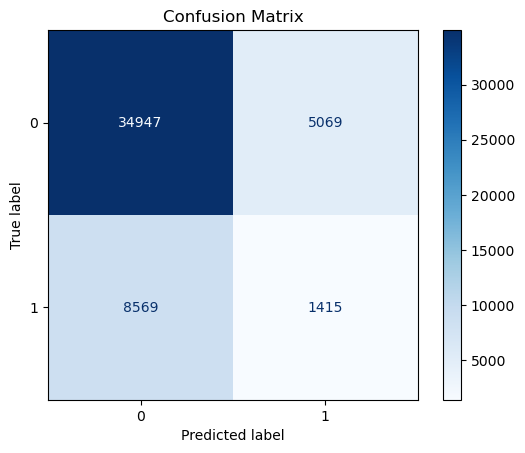

In [251]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
